# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

for i,j in enumerate(y):
    if j == 0:
        y[i] = -1
    elif j == 1:
        y[i] = 1


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X.shape,y.shape


((569, 30), (569,))

## 1. Implementing the PEGASOS SVM (55 points)
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)


1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

In [4]:
# !pip install fastText

from pprint import pprint
from io import open
from numpy import linalg
from collections import defaultdict,Counter
# from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV,ShuffleSplit,cross_val_score,KFold
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn import preprocessing
# from fastText import load_model
from pathlib import Path
from sklearn.base import BaseEstimator

# def warn(*args, **kwargs):
#     pass
# import warningsloss_func
# warnings.warn = warn

class PegasosSVM(BaseEstimator):
    def __init__(self,T=10,lamb=1e-3):
        self.pos_cl = 1
        self.neg_cl = -1
        self.T=T
        self.lamb = lamb
        self.loss_func = self.update_hinge

    def update_hinge(self,score,yi,xi,eta,w):
        if yi*score < 1:
            return (1 - eta*self.lamb)*w + eta*yi*xi
        else:
            return (1 - eta*self.lamb)*w

#     def update_log(self,score,yi,xi,eta,w):
#         return (1 - eta*self.lamb)*w + xi*eta*(yi/(1+expit(yi*score)))

    def fit(self,x,y):
#         try:
#             x=x.toarray()
#         except AttributeError:
#             pass
#         x = np.insert(x,x.shape[1],1,axis=1)
        m,n = x.shape[0],x.shape[1] ## m --> number of samples , n --> number of features
        self.w = np.zeros(n)
        y = list(y)
        for i in range(self.T):
            eta = 1 / (self.lamb*(i+1))
            j = np.random.randint(0,m)
            #j=self.init_index
            xi, yi = x[j], y[j]
            score = xi.dot(self.w)
            self.w = self.loss_func(score,yi,xi,eta,self.w)
#         print("fitting step is complete :)\n")
        return self

    def predict(self,x):
        try:
            x=x.toarray()
        except AttributeError:
            pass
#         x = np.insert(x,x.shape[1],1,axis=1)
        scores = x.dot(self.w)
        out = np.select([scores>=0.0, scores<0.0], [self.pos_cl, self.neg_cl])
        return out

In [6]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

###################PegasosSVM##########################
model_Pegasos = PegasosSVM()

scores_Pegasos = cross_val_score(model_Pegasos, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Pegasos cross_val_score on the train set= %f' %(np.mean(scores_Pegasos)))

model_Pegasos.fit(X_train, y_train)
y_pred_Pegasos = model_Pegasos.predict(X_test)

print('Pegasos accuracy on the test set = %f' %(accuracy_score(y_test, y_pred_Pegasos)))

###################LinearSVC##########################
model_LinearSVC = LinearSVC()

scores_LinearSVC = cross_val_score(model_LinearSVC, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('LinearSVC cross_val_score on the train set= %f' %(np.mean(scores_LinearSVC)))

model_LinearSVC.fit(X_train, y_train)
y_pred_LinearSVC =model_LinearSVC.predict(X_test)
print('LinearSVC accuracy on the test set = %f' %(accuracy_score(y_test, y_pred_LinearSVC)))

Pegasos cross_val_score on the train set= 0.879509
Pegasos accuracy on the test set = 0.824561
LinearSVC cross_val_score on the train set= 0.966581
LinearSVC accuracy on the test set = 0.976608


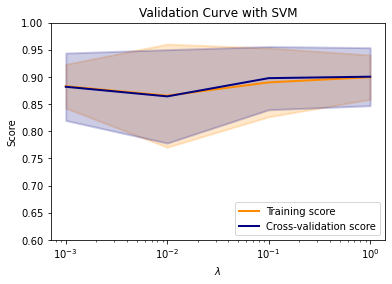

In [9]:
from sklearn.model_selection import validation_curve  
import matplotlib.pyplot as plt

###################Validation Curve##########################
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model_Pegasos = PegasosSVM()
param_range = [1e-3, 1e-2, 1e-1, 1e-0]
train_scores, test_scores = validation_curve(
    model_Pegasos, X_train, y_train, param_name="lamb", param_range=param_range,
    cv=cv, scoring="accuracy", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(6,4))
plt.title("Validation Curve with SVM")
plt.xlabel('$\lambda$')
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="lower right")
plt.show()

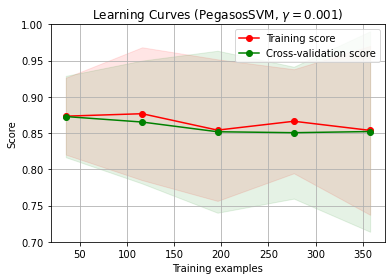

In [10]:
from sklearn.model_selection import learning_curve  

###################Learning Curve##########################
model_Pegasos = PegasosSVM()

train_sizes=np.linspace(0.1, 1.0, 5),
title = 'Learning Curves (PegasosSVM, $\gamma=0.001$)'
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

plt.figure(figsize=(6,4))
plt.title(title)
plt.ylim(0.7,1.0)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    model_Pegasos, X_train, y_train,
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True,
    scoring="accuracy"
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

###################Plotting##########################
plt.grid()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend(loc="best")

plt.show()

## 2. The importance of class weighting in SVM (15)
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


no weights balanced accuracy = 0.951515
balanced weights balanced accuracy = 0.869697
no weights balanced accuracy = 0.893500
balanced weights balanced accuracy = 0.929967


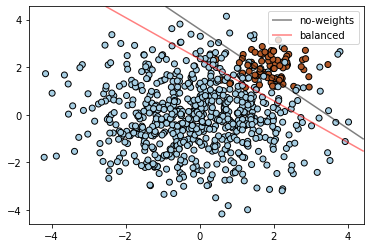

In [11]:
import numpy as np
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)


wclf = svm.SVC(kernel="linear", class_weight='balanced')
wclf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors="k")

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = clf.decision_function(xy).reshape(XX.shape)

a = ax.contour(XX, YY, Z, colors="k", levels=[0], alpha=0.5, linestyles=["-"])

Z = wclf.decision_function(xy).reshape(XX.shape)

b = ax.contour(XX, YY, Z, colors="r", levels=[0], alpha=0.5, linestyles=["-"])

plt.legend(
    [a.collections[0], b.collections[0]],
    ["no-weights", "balanced"],
    loc="upper right",
)

print('no weights balanced accuracy = %f' %(accuracy_score(y_test, clf.predict(X_test))))
print('balanced weights balanced accuracy = %f' %(accuracy_score(y_test, wclf.predict(X_test))))

print('no weights balanced accuracy = %f' %(balanced_accuracy_score(y_test, clf.predict(X_test))))
print('balanced weights balanced accuracy = %f' %(balanced_accuracy_score(y_test, wclf.predict(X_test))))


**Answer:** 
After using balanced weights the accuracy improved because we gave more weights to less frequent class.

## 3. SVM hyperparameter search (10)
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn import svm

@ignore_warnings(category=ConvergenceWarning)
def hyperparameter_search():
    clf = LinearSVC()
    score = cross_val_score(clf, X, y, n_jobs=-1,cv=5)
    mean_score_LinearSVC = np.mean(score)

#     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
#     clf = svm.LinearSVC()
    params=[{'multi_class':['ovr', 'crammer_singer'], 'loss':['hinge', 'squared_hinge'], 'C': np.logspace(-3,3,10)}]
    clf_grid = GridSearchCV(clf,param_grid=params, cv=5, verbose=1, n_jobs=-1)
    clf_grid.fit(X, y)

    print('best_params for GridSearchCV = ', clf_grid.best_params_)
    print('best_score for GridSearchCV =', clf_grid.best_score_)
    print('best_score for default LinearSVC =', mean_score_LinearSVC)

    
hyperparameter_search()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best_params for GridSearchCV =  {'C': 0.001, 'loss': 'hinge', 'multi_class': 'ovr'}
best_score for GridSearchCV = 0.5683333333333334
best_score for default LinearSVC = 0.5683333333333334


**Answer:** We can see that in the last execution default LinearSVC score was **0.92** and using GridSearchCV with optimized hyper params  best score was **0.95**. Therefore, as expected, optimizing hyper params yields better score.

## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [13]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

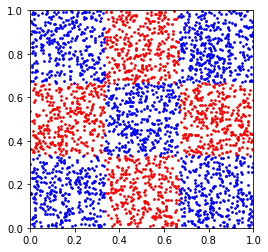

In [14]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(4,4))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [15]:
from sklearn.svm import SVC

x_train, y_train = checkerboard(2000)
x_test, y_test = checkerboard(1000)


param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree':[1,2,4,6,8,10],
              'kernel': ['poly']}
grid_poly = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1) 
grid_poly.fit(x_train, y_train)

print('poly best_params_: ', grid_poly.best_params_)
print('poly best_score_: ', grid_poly.best_score_)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}
grid_rbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1) 
grid_rbf.fit(x_train, y_train)


print('rbf best_params_: ', grid_rbf.best_params_)
print('rbf best_score_: ', grid_rbf.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
poly best_params_:  {'C': 1000, 'degree': 10, 'gamma': 1, 'kernel': 'poly'}
poly best_score_:  0.7015
Fitting 5 folds for each of 20 candidates, totalling 100 fits
rbf best_params_:  {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
rbf best_score_:  0.9359999999999999


In [16]:
# print('best_params_: ', grid.best_params_)
# print('best_score_: ', grid.best_score_)
# print('best_estimator_: ',grid.best_estimator_)
# grid.cv_results_
# grid_poly.best_estimator_.n_support_
# # grid_rbf.best_estimator_.n_support_
# grid_poly.best_estimator_.support_vectors_

**Answer:**  According to last execution:<br>
For polynomial kernel, the optimal degree is 8, gamma = 1, C=1000 and score is 0.7 <br>
For rbf kernel, the optimal gamma is 1 (=> sigma = sqrt(1/(2*gamma)) = 0.7), C=1000 and score is 0.93

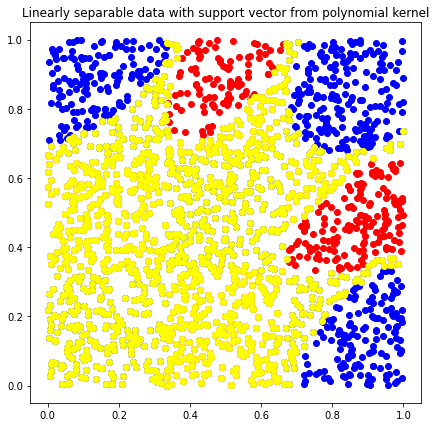

In [17]:
support_vectors_poly= grid_poly.best_estimator_.support_vectors_

plt.figure(figsize=(7,7))
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='r')
plt.scatter(x_train[y_train==-1,0], x_train[y_train==-1,1], c='b')

plt.scatter(support_vectors_poly[:,0], support_vectors_poly[:,1], color='yellow')
plt.title('Linearly separable data with support vector from polynomial kernel')

# plt.xlim([0,1])
# plt.ylim([0,1]);
plt.show()

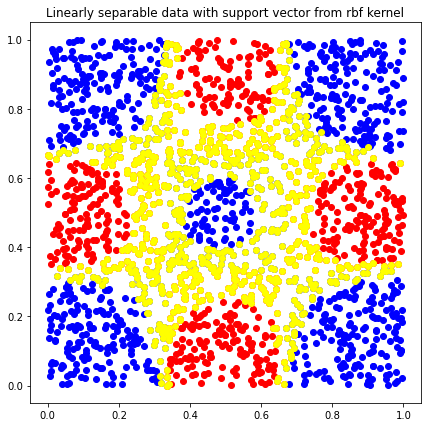

In [18]:
support_vectors_rbf= grid_rbf.best_estimator_.support_vectors_

plt.figure(figsize=(7,7))
# plt.scatter(x_train[:,0],x_train[:,1], y_train, cmap='winter')

# plt.figure(figsize=(3,3))
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='r')
plt.scatter(x_train[y_train==-1,0], x_train[y_train==-1,1], c='b')

plt.scatter(support_vectors_rbf[:,0], support_vectors_rbf[:,1], color='yellow')
plt.title('Linearly separable data with support vector from rbf kernel')
# plt.xlim([0,1])
# plt.ylim([0,1]);

plt.show()

**Answer:**  We can see from the plot aboce that the supporting vector of RBF is doing much better job than 
the supporting vector from Polynomial kernel. As expected from the score we got before.
One more time we see that RBF is better than polynomial kernel.


## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

